## 45단계: 계층을 모아두는 계층층

> .

### 45.1 Layer 클래스 확장

Layer 클래스에 Parameter뿐 아니라 Layer도 포함할 수 있게 한다.

<img src="images/그림 45-1.png" width=600/>

In [1]:
# dezero/layers.py
from dezero.core import Parameter

class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):  # 1. Layer도 추가
            self._params.add(name)
        super().__setattr__(name, value)
        
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]
                
            if isinstance(obj, Layer):  # 2. Layer에서 매개변수 꺼내기
                yield from obj.params()
            else:
                yield obj
    
    ...

In [2]:
# Sample Usage
import dezero.layers as L
import dezero.functions as F
from dezero import Layer

model = Layer()
model.l1 = L.Linear(5)  # 출력 크기만 지정
model.l2 = L.Linear(3)

# 추론 함수
def predict(x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

# 모든 매개변수에 접근
for p in model.params():
    print(p)
    
# 모든 매개변수의 기울기를 재설정
model.cleargrads()

Variable([0. 0. 0.])
Variable(None)
Variable([0. 0. 0. 0. 0.])
Variable(None)


In [3]:
# Layer 클래스를 상속하여 하나의 모델로 구성하기

class TwoLayerModel(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        return y

### 45.2 Model 클래스

Layer 클래스에 시각화 메서드 추가

In [4]:
# dezero/models.py

from dezero import Layer, utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

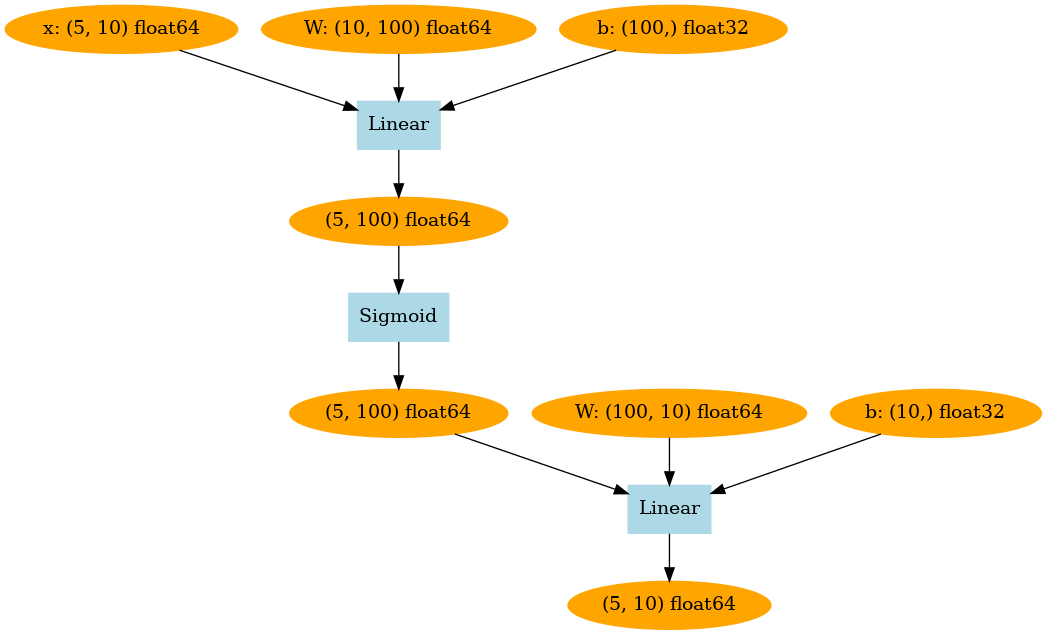

In [5]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

### 45.3 Model을 사용한 문제 해결

토이 데이터셋을 이용한 회귀 문제 Revisit

In [6]:
import numpy as np
from dezero import Variable, Model
import dezero.layers as L
import dezero.functions as F

# 데이터셋 생성
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# 하이퍼파라미터 설정
lr = 0.2
max_iter = 10000
hidden_size = 10

# 모델 정의
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

model = TwoLayerNet(hidden_size, 1)

# 학습 시작
for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

Variable(0.8165178479901415)
Variable(0.2499028014603371)
Variable(0.24609874026436834)
Variable(0.23721586110833612)
Variable(0.20793217994822147)
Variable(0.12311919860580518)
Variable(0.07888168390348675)
Variable(0.07656075297857305)
Variable(0.07643364647799142)
Variable(0.0761937449484299)


### 45.4 MLP 클래스

더 범용적인 완전연결계층(Fully Connected Layer) 신경망 구현

In [7]:
# dezero/models.py

import dezero.functions as F
import dezero.layers as L

class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []
        
        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)
    
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

In [8]:
# Sample Usage
model = MLP((10, 1))  # 2층
model = MLP((10, 20, 30, 40, 1))  # 5층